# Poppy Universe – Layer 4: Star Neural Network Model

Welcome to the **Poppy Universe Layer 4 – Star Neural Network notebook**!  
This notebook implements a **neural network-based recommendation model** using user interactions and star types. This uses a **from-scratch NN implementation** without deep learning libraries.

> Note: This notebook currently uses **simulated user interactions** to test the Star NN model.  
> Once we have enough real interactions, the same pipeline will process actual user data for production recommendations.

---

## Goals

1. **Prepare interaction data for neural network training**  
    - Encode users and star types  
    - Create training dataset with one-hot encoding  
    - Split into train/validation sets

2. **Build and train the Neural Network from scratch**  
    - Initialize weights and biases  
    - Implement forward propagation  
    - Implement backpropagation with gradient descent  
    - Train with mini-batch updates

3. **Generate predictions for all user × star_type combinations**  
    - Create complete prediction matrix  
    - Save intermediate CSV for engine integration

4. **Analyze results**  
    - Visualize training loss  
    - Compare predictions with actual interactions

---

## Folder & File References

- **../../Input_Data/Semantic_Type_Interactions.csv** → User interaction dataset  
- **Files/Layer4_Star_Predictions.csv** → Final predictions for engine  
- **Plots/** → Optional training curves or visualizations

---


## 0) Imports

In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

## 1) Load Data

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# --- Load interaction dataset ---
# 'backend_df' is injected via papermill by the master notebook if backend data passed the checks
try:
    interactions = backend_df
    print("Using backend-provided interactions")
except NameError:
    # fallback to CSV if running standalone
    interactions = pd.read_csv("../../../Input_Data/NN_Semantic_Interactions.csv")
    print("Using simulated CSV interactions")

# Ensure Timestamp is datetime
interactions['Timestamp'] = pd.to_datetime(interactions['Timestamp'])

# Preview
print(f"Total interactions: {len(interactions)}")
print(f"Unique users: {interactions['User_ID'].nunique()}")
print(f"Unique categories: {interactions['Category_Type'].nunique()}")
interactions.head()

Using simulated CSV interactions
Total interactions: 12000
Unique users: 120
Unique categories: 3


,Interaction_ID,User_ID,Category_Type,Category_Value,Strength,Timestamp
0,1,50,Star,M,1,2025-11-30 02:02:11.902417
1,2,74,Star,A,5,2025-12-06 20:59:09.242640
2,3,24,Moon,Saturn,2,2025-10-26 01:39:58.938016
3,4,101,Planet,Dwarf Planet,3,2025-11-10 03:54:02.183020
4,5,110,Star,M,1,2025-11-25 05:24:18.392856


**Explanation:**  
We're loading the simulated user × type interaction data. The key columns are:
  
- `Interaction_ID`: unique identifier for each interaction  
- `User_ID`: the user who performed the interaction  
- `Category_Type`: the type of category (Star, Planet, Moon)  
- `Category_Value`: the specific value (e.g., "Earth")  
- `Strength`: numerical interaction strength (1–5), our target variable  
- `Timestamp`: when the interaction occurred  

## 2) Filter Star Data

In [4]:
# Keep only rows where Category_Type is "Star"
star_interactions = interactions[interactions['Category_Type'] == 'Star'].copy()

print(f"Star interactions: {len(star_interactions)}")
print(f"Unique users: {star_interactions['User_ID'].nunique()}")
print(f"Unique Stars: {star_interactions['Category_Value'].nunique()}")
print(f"\Star values:")
print(star_interactions['Category_Value'].value_counts())

star_interactions.head()

Star interactions: 4736
Unique users: 120
Unique Stars: 7
\Star values:
Category_Value
O    714
M    687
A    677
K    673
F    666
B    665
G    654
Name: count, dtype: int64


<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:7: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Jelle\AppData\Local\Temp\ipykernel_11160\425126113.py:7: SyntaxWarning: invalid escape sequence '\S'
  print(f"\Star values:")


,Interaction_ID,User_ID,Category_Type,Category_Value,Strength,Timestamp
0,1,50,Star,M,1,2025-11-30 02:02:11.902417
1,2,74,Star,A,5,2025-12-06 20:59:09.242640
4,5,110,Star,M,1,2025-11-25 05:24:18.392856
9,10,102,Star,G,2,2025-11-27 22:29:40.189402
11,12,118,Star,A,4,2025-11-30 16:01:35.659818


## 3) Encode Users and Stars

In [5]:
# Encode users and Star parents as integers
user_encoder = LabelEncoder()
star_encoder = LabelEncoder()

star_interactions['user_encoded'] = user_encoder.fit_transform(star_interactions['User_ID'])
star_interactions['star_encoded'] = star_encoder.fit_transform(star_interactions['Category_Value'])

# Store mappings for later use
num_users = star_interactions['user_encoded'].nunique()
num_star = star_interactions['star_encoded'].nunique()

print(f"Encoded users: {num_users}")
print(f"Encoded stars: {num_star}")
print(f"Strength range: {star_interactions['Strength'].min()} - {star_interactions['Strength'].max()}")

star_interactions.head()

Encoded users: 120
Encoded stars: 7
Strength range: 1 - 5


,Interaction_ID,User_ID,Category_Type,Category_Value,Strength,Timestamp,user_encoded,star_encoded
0,1,50,Star,M,1,2025-11-30 02:02:11.902417,49,5
1,2,74,Star,A,5,2025-12-06 20:59:09.242640,73,0
4,5,110,Star,M,1,2025-11-25 05:24:18.392856,109,5
9,10,102,Star,G,2,2025-11-27 22:29:40.189402,101,3
11,12,118,Star,A,4,2025-11-30 16:01:35.659818,117,0


## 4) Prepare Training Data

In [6]:
# Extract features and target
X_user = star_interactions['user_encoded'].values
X_star = star_interactions['star_encoded'].values
y = star_interactions['Strength'].values

# Normalize target to 0-1 range for better training
scaler = MinMaxScaler()
y_normalized = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Split into train and validation sets
X_user_train, X_user_val, X_star_train, X_star_val, y_train, y_val = train_test_split(
    X_user, X_star, y_normalized, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_user_train)}")
print(f"Validation samples: {len(X_user_val)}")

Training samples: 3788
Validation samples: 948


## 5) Neural Network Helper Functions

In [7]:
def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # clip to prevent overflow

def sigmoid_derivative(z):
    """Derivative of sigmoid function"""
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    """ReLU activation function"""
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU function"""
    return (z > 0).astype(float)

def mse_loss(y_true, y_pred):
    """Mean squared error loss"""
    return np.mean((y_true - y_pred) ** 2)

def initialize_parameters(layer_dims):
    """
    Initialize weights and biases for all layers
    
    Args:
        layer_dims: list of layer sizes [input, hidden1, hidden2, ..., output]
    
    Returns:
        parameters: dictionary containing W1, b1, W2, b2, ...
    """
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        # He initialization for weights
        parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
    
    return parameters

def forward_propagation(X, parameters, activation='relu'):
    """
    Forward pass through the network
    
    Args:
        X: input features (input_size, m)
        parameters: dictionary of weights and biases
        activation: 'relu' or 'sigmoid' for hidden layers
    
    Returns:
        AL: output of the network
        caches: list of (Z, A_prev) for backprop
    """
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers
    
    # Hidden layers
    for l in range(1, L):
        A_prev = A
        Z = parameters[f'W{l}'] @ A_prev + parameters[f'b{l}']
        
        if activation == 'relu':
            A = relu(Z)
        else:
            A = sigmoid(Z)
        
        caches.append((Z, A_prev))
    
    # Output layer (sigmoid)
    A_prev = A
    Z = parameters[f'W{L}'] @ A_prev + parameters[f'b{L}']
    AL = sigmoid(Z)
    caches.append((Z, A_prev))
    
    return AL, caches

def backward_propagation(AL, Y, caches, parameters, activation='relu'):
    """
    Backward pass through the network
    
    Args:
        AL: output of forward prop
        Y: true labels
        caches: list of (Z, A_prev) from forward prop
        parameters: current weights and biases
        activation: 'relu' or 'sigmoid' for hidden layers
    
    Returns:
        grads: dictionary of gradients
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    
    # Output layer gradient
    dZ = AL - Y
    grads[f'dW{L}'] = (1/m) * dZ @ caches[L-1][1].T
    grads[f'db{L}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    
    # Hidden layers
    for l in reversed(range(1, L)):
        Z, A_prev = caches[l-1]
        dA = parameters[f'W{l+1}'].T @ dZ
        
        if activation == 'relu':
            dZ = dA * relu_derivative(Z)
        else:
            dZ = dA * sigmoid_derivative(Z)
        
        grads[f'dW{l}'] = (1/m) * dZ @ A_prev.T
        grads[f'db{l}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    
    return grads

def update_parameters(parameters, grads, learning_rate):
    """Update parameters using gradient descent"""
    L = len(parameters) // 2
    
    for l in range(1, L + 1):
        parameters[f'W{l}'] -= learning_rate * grads[f'dW{l}']
        parameters[f'b{l}'] -= learning_rate * grads[f'db{l}']
    
    return parameters

## 6) Prepare Input Features (One-Hot Encoding)

In [8]:
def create_one_hot(indices, num_classes):
    """Create one-hot encoded matrix"""
    one_hot = np.zeros((num_classes, len(indices)))
    one_hot[indices, np.arange(len(indices))] = 1
    return one_hot

# Create one-hot encoded features
X_train_user_onehot = create_one_hot(X_user_train, num_users)
X_train_star_onehot = create_one_hot(X_star_train, num_star)
X_train = np.vstack([X_train_user_onehot, X_train_star_onehot])

X_val_user_onehot = create_one_hot(X_user_val, num_users)
X_val_star_onehot = create_one_hot(X_star_val, num_star)
X_val = np.vstack([X_val_user_onehot, X_val_star_onehot])

# Reshape y
Y_train = y_train.reshape(1, -1)
Y_val = y_val.reshape(1, -1)

print(f"Training input shape: {X_train.shape}")
print(f"Training output shape: {Y_train.shape}")
print(f"Validation input shape: {X_val.shape}")
print(f"Validation output shape: {Y_val.shape}")


Training input shape: (127, 3788)
Training output shape: (1, 3788)
Validation input shape: (127, 948)
Validation output shape: (1, 948)


## 7) Train Neural Network

In [9]:
# Network architecture
input_size = num_users + num_star
hidden_layers = [64, 32, 16]
output_size = 1
layer_dims = [input_size] + hidden_layers + [output_size]

print(f"Network architecture: {layer_dims}")

# Initialize parameters
parameters = initialize_parameters(layer_dims)

# Training hyperparameters
learning_rate = 0.01
num_epochs = 1000
print_every = 100

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Forward propagation
    AL_train, caches = forward_propagation(X_train, parameters, activation='relu')
    
    # Compute training loss
    train_loss = mse_loss(Y_train, AL_train)
    train_losses.append(train_loss)
    
    # Backward propagation
    grads = backward_propagation(AL_train, Y_train, caches, parameters, activation='relu')
    
    # Update parameters
    parameters = update_parameters(parameters, grads, learning_rate)
    
    # Validation loss
    AL_val, _ = forward_propagation(X_val, parameters, activation='relu')
    val_loss = mse_loss(Y_val, AL_val)
    val_losses.append(val_loss)
    
    # Print progress
    if (epoch + 1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

print("\nTraining complete!")

Network architecture: [127, 64, 32, 16, 1]
Epoch 100/1000 - Train Loss: 0.102298, Val Loss: 0.101108
Epoch 200/1000 - Train Loss: 0.102048, Val Loss: 0.100623
Epoch 300/1000 - Train Loss: 0.101913, Val Loss: 0.100428
Epoch 400/1000 - Train Loss: 0.101806, Val Loss: 0.100329
Epoch 500/1000 - Train Loss: 0.101713, Val Loss: 0.100273
Epoch 600/1000 - Train Loss: 0.101629, Val Loss: 0.100236
Epoch 700/1000 - Train Loss: 0.101550, Val Loss: 0.100213
Epoch 800/1000 - Train Loss: 0.101475, Val Loss: 0.100194
Epoch 900/1000 - Train Loss: 0.101405, Val Loss: 0.100181
Epoch 1000/1000 - Train Loss: 0.101339, Val Loss: 0.100173

Training complete!


## 8) Visualize Training

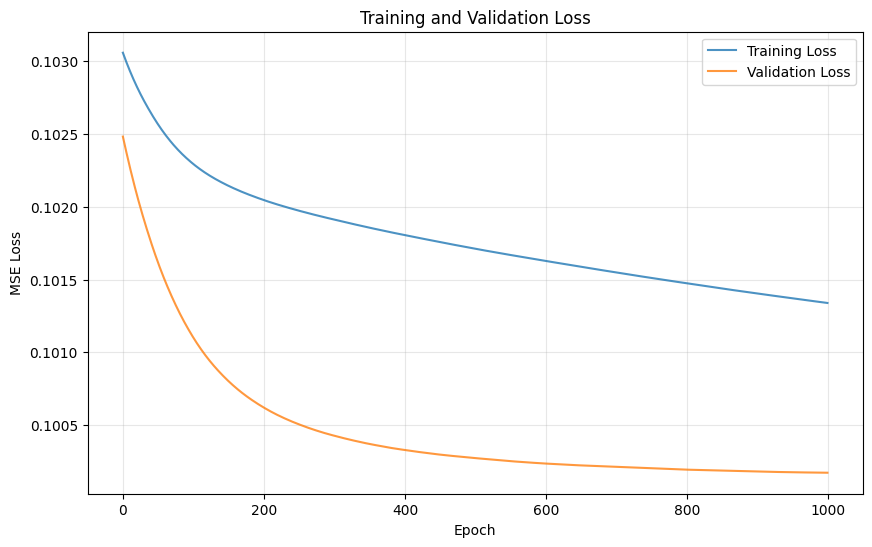

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../Plots/L4_star_nn_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

## 9) Generate Full Prediction Matrix

In [11]:
# Create all possible user × star combinations
all_users = np.arange(num_users)
all_star = np.arange(num_star)

# Create meshgrid
user_grid, star_grid = np.meshgrid(all_users, all_star, indexing='ij')
user_flat = user_grid.flatten()
star_flat = star_grid.flatten()

# One-hot encode
X_all_user_onehot = create_one_hot(user_flat, num_users)
X_all_star_onehot = create_one_hot(star_flat, num_star)
X_all = np.vstack([X_all_user_onehot, X_all_star_onehot])

# Generate predictions
predictions_normalized, _ = forward_propagation(X_all, parameters, activation='relu')

# Denormalize predictions back to original scale
predictions = scaler.inverse_transform(predictions_normalized.T).flatten()

# Clip to valid range [1, 5]
predictions = np.clip(predictions, 1, 5)

print(f"Generated {len(predictions)} predictions")
print(f"Prediction range: {predictions.min():.2f} - {predictions.max():.2f}")

Generated 840 predictions
Prediction range: 3.01 - 3.82


## 10) Convert to DataFrame

In [12]:
# Reshape predictions into matrix
prediction_matrix = predictions.reshape(num_users, num_star)

# Decode user and star IDs
user_ids = user_encoder.inverse_transform(all_users)
star_values = star_encoder.inverse_transform(all_star)

# Create DataFrame
R_hat_df = pd.DataFrame(prediction_matrix, columns=star_values)
R_hat_df.insert(0, 'User_ID', user_ids)

print(R_hat_df.head())

   User_ID         A         B         F         G         K         M  \
0        1  3.374687  3.487968  3.329048  3.275489  3.392254  3.299045   
1        2  3.230555  3.348081  3.256040  3.245267  3.367671  3.377338   
2        3  3.304385  3.362777  3.269798  3.283165  3.407863  3.429173   
3        4  3.171066  3.396097  3.287523  3.289830  3.438737  3.458244   
4        5  3.372962  3.582070  3.378999  3.355742  3.606762  3.389783   

          O  
0  3.303601  
1  3.075759  
2  3.193878  
3  3.366086  
4  3.298792  


## 11) Save Predictions to CSV

In [13]:
# Ensure output directory exists
#os.makedirs('Files', exist_ok=True)

# Save as CSV for master notebook
R_hat_df.to_csv('../Files/Layer4_Star_Predictions.csv', index=False)

print("Predictions saved to ../Files/Layer4_Star_Predictions.csv")
print(f"Shape: {R_hat_df.shape}")

Predictions saved to ../Files/Layer4_Star_Predictions.csv
Shape: (120, 8)


## 12) Analyze Predictions

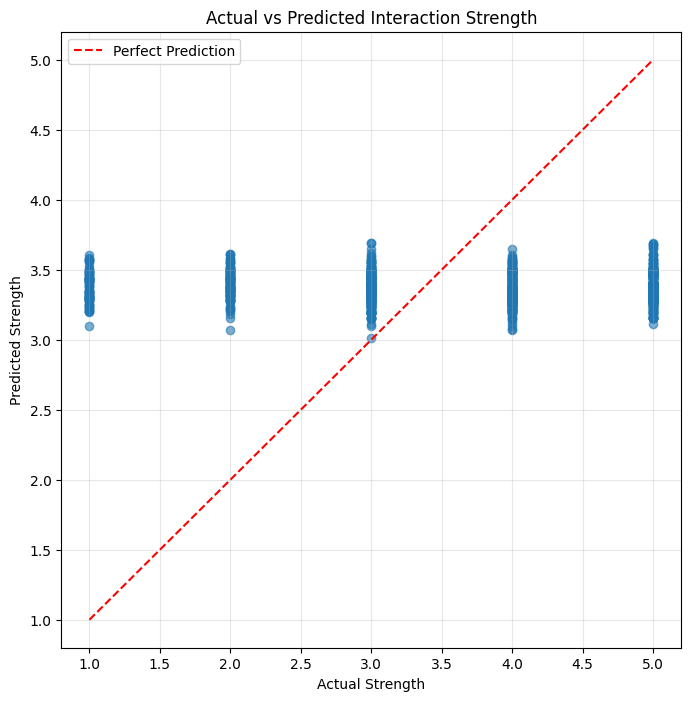

Validation MAE: 1.0777
Validation RMSE: 1.2660


In [14]:
# Compare actual vs predicted for validation set
AL_val_pred, _ = forward_propagation(X_val, parameters, activation='relu')
y_val_pred = scaler.inverse_transform(AL_val_pred.T).flatten()
y_val_actual = scaler.inverse_transform(Y_val.T).flatten()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_val_actual, y_val_pred, alpha=0.6)
plt.plot([1, 5], [1, 5], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength')
plt.title('Actual vs Predicted Interaction Strength')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../Plots/L4_Stars_nn_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute metrics
mae = np.mean(np.abs(y_val_actual - y_val_pred))
rmse = np.sqrt(np.mean((y_val_actual - y_val_pred) ** 2))

print(f"Validation MAE: {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

## Summary
 
This notebook successfully:
1. ✅ Loaded and filtered star interactions
2. ✅ Implemented a neural network from scratch (no deep learning libraries)
3. ✅ Trained the model using forward/backward propagation
4. ✅ Generated predictions for all user × star combinations
5. ✅ Saved the prediction matrix for engine consumption
 
The predictions are now ready to be used in the recommendation engine!